In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tte
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import copy


import pymc3 as pm
import scipy as sp
import scipy.stats as stats

import cv2
import cw_utils
import cw_plots

import pickle

In [35]:
import importlib
importlib.reload(cw_plots)

<module 'cw_plots' from '/Users/nickhoernle/Harvard/essil/baseline_model/cw_plots.py'>

In [2]:
data_csvs = {}
data_csvs_bin = {}
data_csvs_raw = {}
path = './../data/test_data/'
names = [
    "test1-2017-11-03T09-31.csv",
    "test2-2017-11-08T09-19.csv",
    "test3-2017-11-09T09-23.csv",
    "test4-2017-11-10T09-24.csv",
    "test5-2017-11-16T11-41.csv"
]
data_csvs['df_1'] = pd.read_csv(path+ names[0]).iloc[6:]
data_csvs['df_2'] = pd.read_csv(path+ names[1]).iloc[6:]
data_csvs['df_3'] = pd.read_csv(path+ names[2]).iloc[6:]
data_csvs['df_4'] = pd.read_csv(path+ names[3]).iloc[6:]
data_csvs['df_5'] = pd.read_csv(path+ names[4]).iloc[6:]

data_csvs_raw['df_1'] = pd.read_csv(path+ names[0]).iloc[6:]
data_csvs_raw['df_2'] = pd.read_csv(path+ names[1]).iloc[6:]
data_csvs_raw['df_3'] = pd.read_csv(path+ names[2]).iloc[6:]
data_csvs_raw['df_4'] = pd.read_csv(path+ names[3]).iloc[6:]
data_csvs_raw['df_5'] = pd.read_csv(path+ names[4]).iloc[6:]

biomes = ['Desert', 'Jungle', 'Wetlands', 'Plains']
for k,v in data_csvs.items():
    
    data_csvs[k].columns = data_csvs[k].columns.str.strip()
    data_csvs_raw[k].columns = data_csvs_raw[k].columns.str.strip()
    data_csvs_bin[k] = pd.DataFrame()
    for biome in biomes:
        bins_data = data_csvs_raw[k]['%s_WaterBins'%biome].apply(lambda x: np.sum([float(num) for num in x.split('-')])/40)
        bins_data += data_csvs_raw[k]['%s_FloodBins'%biome].apply(lambda x: np.sum([float(num) for num in x.split('-')])/40)
        data_csvs_bin[k]['%s_Water'%biome] = bins_data
    
    data_csvs[k] = data_csvs[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs[k]['Other_Water'] = 2.5-data_csvs[k].sum(axis=1)
    data_csvs[k] = data_csvs[k] / 2.5
    data_csvs[k] = data_csvs[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    
#     data_csvs_bin[k]['Reservoir_Water'] = data_csvs[k]['Reservoir_Water']
    data_csvs_bin[k] = data_csvs_bin[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs_bin[k]['Other_Water'] = 1-data_csvs_bin[k].sum(axis=1)
    data_csvs_bin[k] = data_csvs_bin[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]

data_csvs['df_2'].head(2)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0


### Convert the .mov files for easier viewing

In [3]:
# don't run this if not necessary
# for f_name in names:
    
#     print(f_name)
#     mov_name = f_name.replace('.csv', '.mov')
#     cw_utils.get_mini_view_video(path + mov_name, path + f_name)

# Run State-Estimation to Find Params

In [4]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "N": N,
           "A": np.eye(N)}

results = {}

### Test 1

In [31]:
df_name = 'df_1'
flag = 0
if ((df_name in results) and (not flag)):
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=5,
                                       starting_params=params,
                                       sensitivity=8)
    results[df_name] = em_res

In [32]:
results['df_1']['breaks']

array([  0,  93, 144, 239, 299, 387])

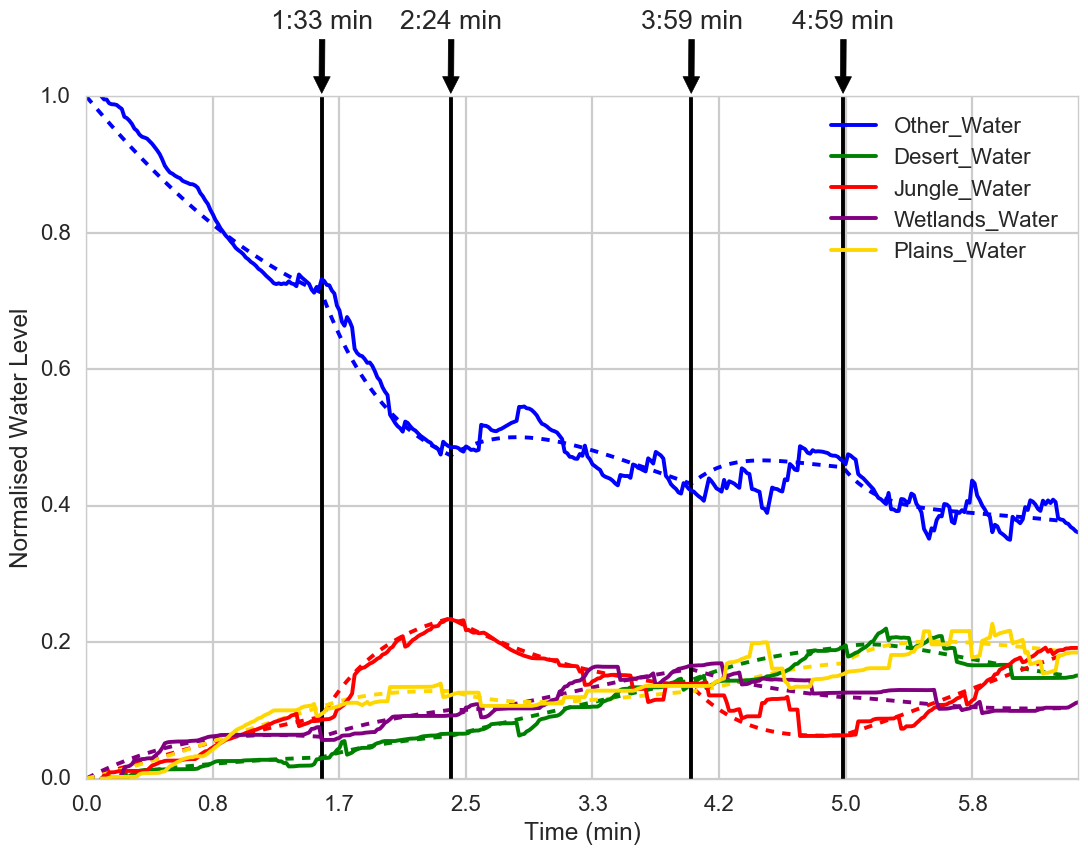

In [36]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

File: test1-2017-11-03T09-31.csv
Split @ 1:33 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Increase in Jungle_Water water
Increase in Wetlands_Water water

******************************************************


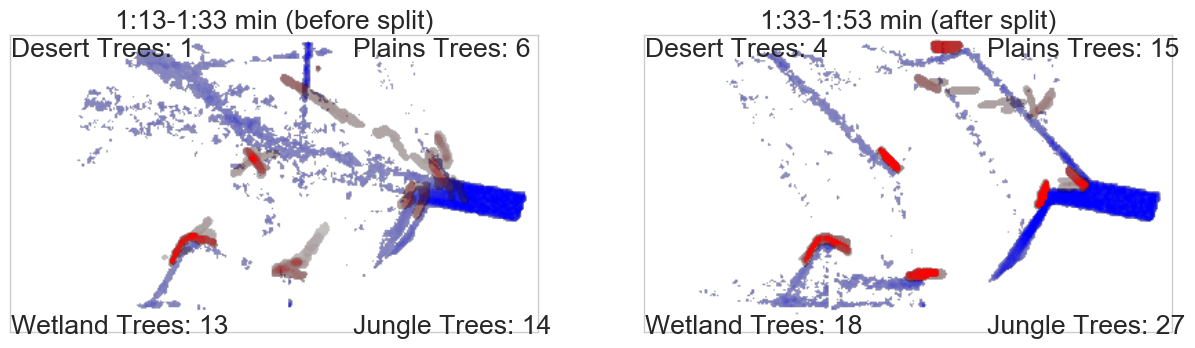

--------------------------------------------------------
--------------------------------------------------------

Split @ 2:24 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Decrease in Jungle_Water water
Increase in Wetlands_Water water
Increase in Plains_Water water

******************************************************


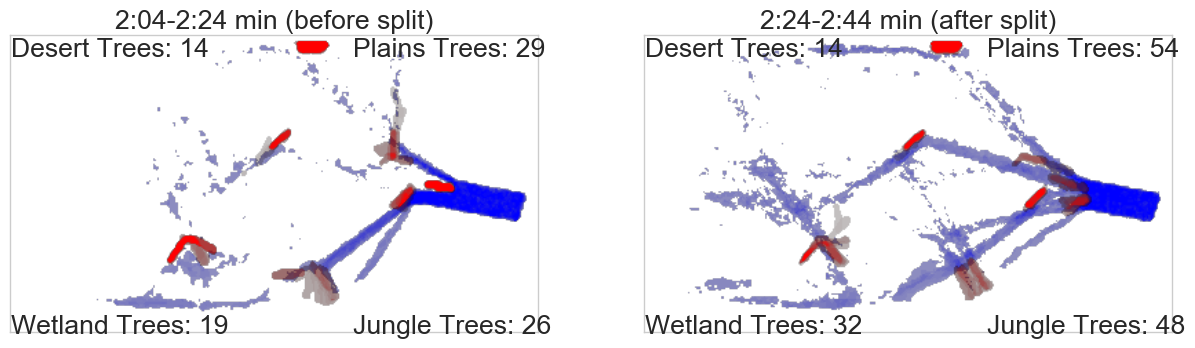

--------------------------------------------------------
--------------------------------------------------------

Split @ 3:59 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Decrease in Wetlands_Water water

******************************************************


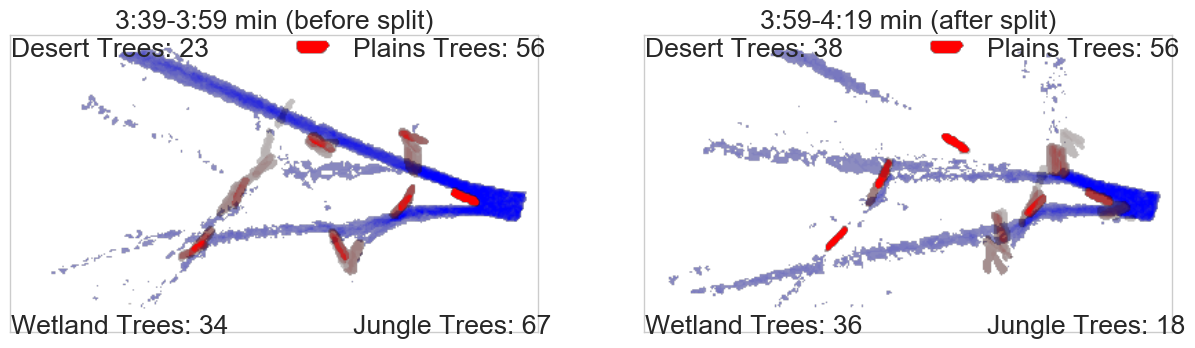

--------------------------------------------------------
--------------------------------------------------------

Split @ 4:59 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Jungle_Water water

******************************************************


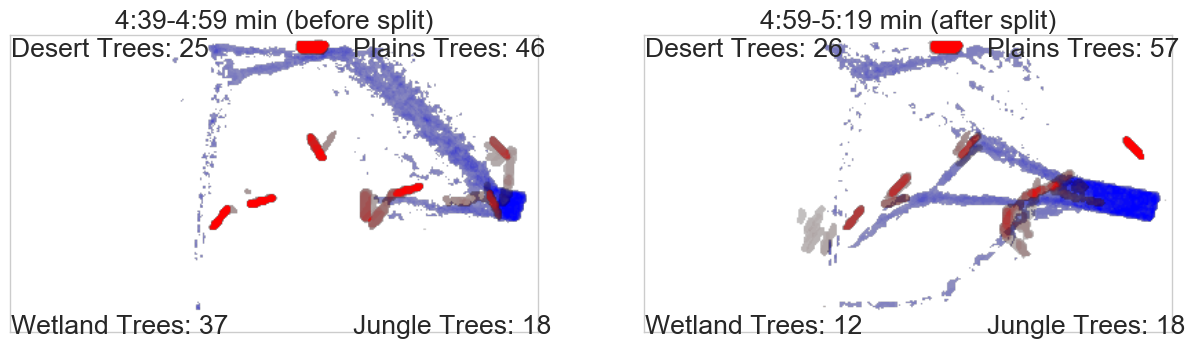

--------------------------------------------------------
--------------------------------------------------------



In [37]:
cw_plots.plot_log_positions(df_name=df_name, 
                            results=results, 
                            names=names, 
                            data_csvs=data_csvs, 
                            data_csvs_raw=data_csvs_raw, 
                            path = './../data/test_data/')

**Points of interest:**
- Split @ 1:33 min - increase in Jungle Water is clear.
- Split @ 2:24 min - decrease in Jungle, increase in Wetlands is clear.
- Split @ 3:59 min - clear decrease in Desert.
- Split @ 4:59 min - Increase in Jungle is still to come.

<hr />
### Test 2

In [38]:
df_name = 'df_2'
flag = 0
if df_name in results and not flag:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=5,
                                       starting_params=params,
                                      sensitivity=0)
    results[df_name] = em_res

In [39]:
results['df_2']['breaks']

array([  0,  84, 156, 316, 396])

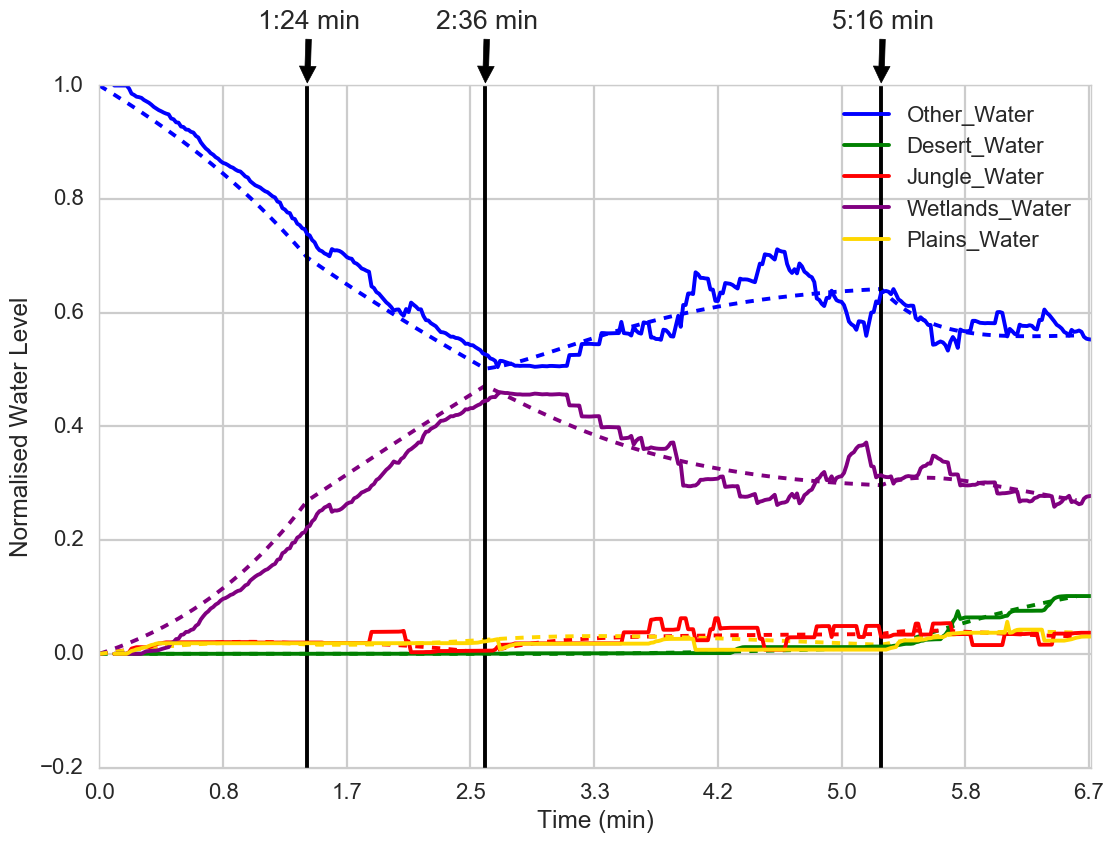

In [40]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

File: test2-2017-11-08T09-19.csv
Split @ 1:24 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Wetlands_Water water

******************************************************


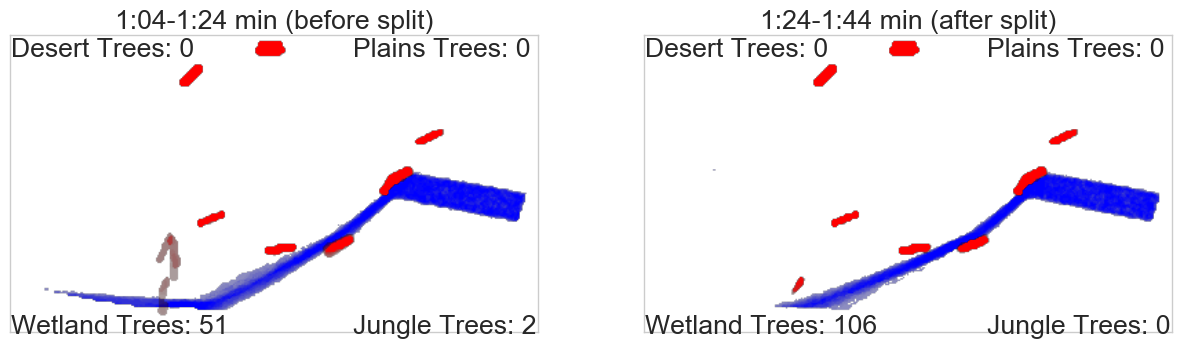

--------------------------------------------------------
--------------------------------------------------------

Split @ 2:36 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Wetlands_Water water

******************************************************


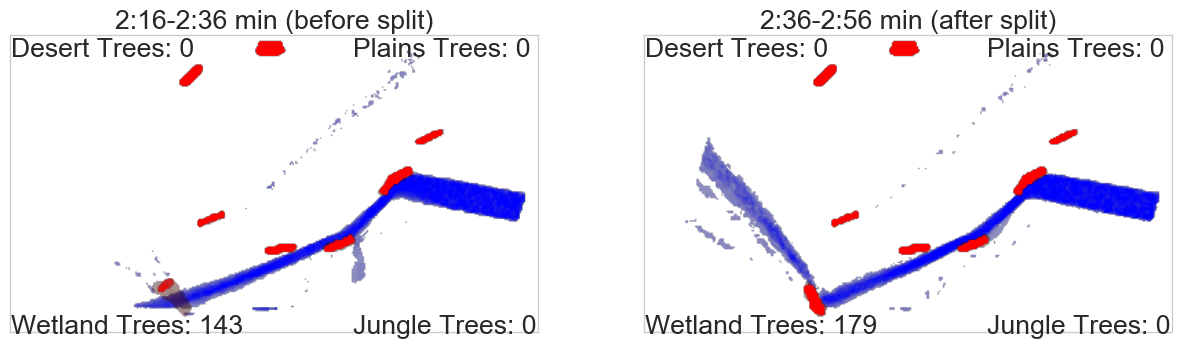

--------------------------------------------------------
--------------------------------------------------------

Split @ 5:16 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Increase in Plains_Water water

******************************************************


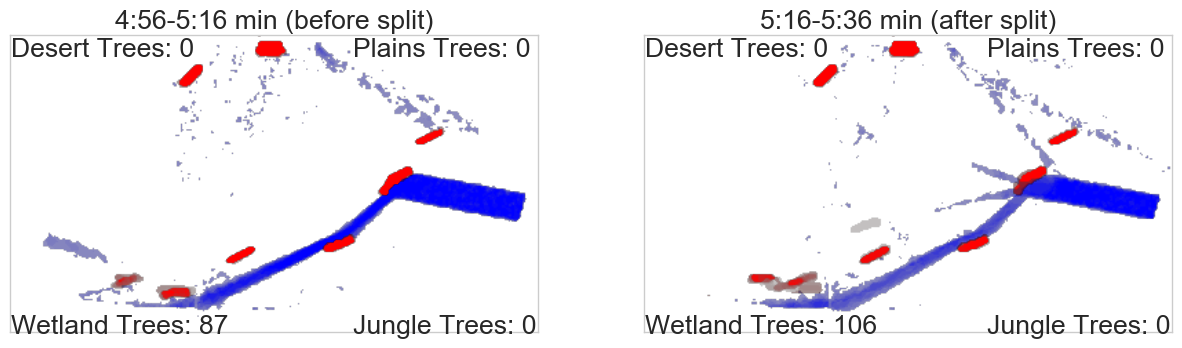

--------------------------------------------------------
--------------------------------------------------------



In [41]:
### df_name = 'df_2'            
cw_plots.plot_log_positions(df_name=df_name, 
                            results=results, 
                            names=names, 
                            data_csvs=data_csvs, 
                            data_csvs_raw=data_csvs_raw, 
                            path = './../data/test_data/')

**Points of interest:**
- Split @ 1:24 min - Here water is still being routed to wetlands but as the water level in wetlands rises, less water is available for the change in water level (which is what is being commented on above).
- Split @ 2:36 min - clear water directed away from wetlands.
- Split @ 5:16 min - not clear what action is linked to this change.

<hr />
### Test 3

In [42]:
df_name = 'df_3'
flag = 0
if df_name in results and not flag:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=5, starting_params=params, sensitivity=0)
    results[df_name] = em_res

In [43]:
results['df_3']['breaks']

array([  0,  73, 200, 236, 396])

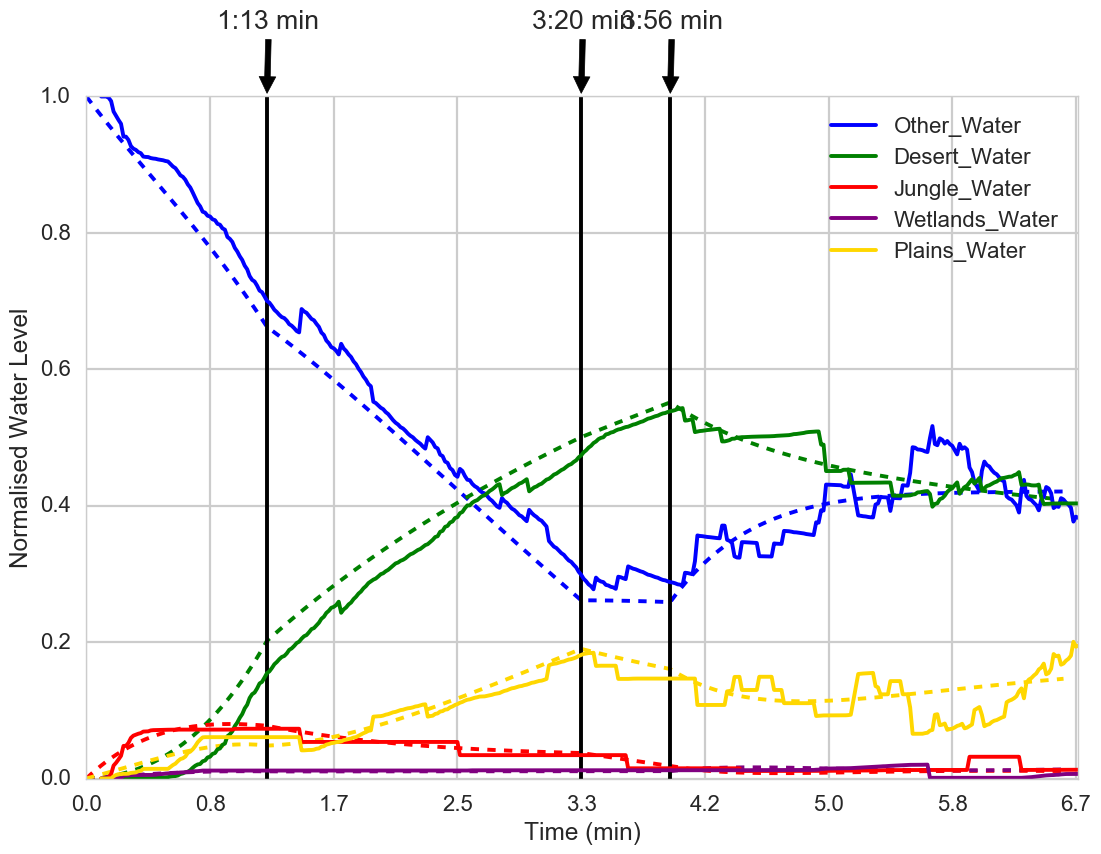

In [44]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

File: test3-2017-11-09T09-23.csv
Split @ 1:13 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Decrease in Jungle_Water water
Increase in Plains_Water water

******************************************************


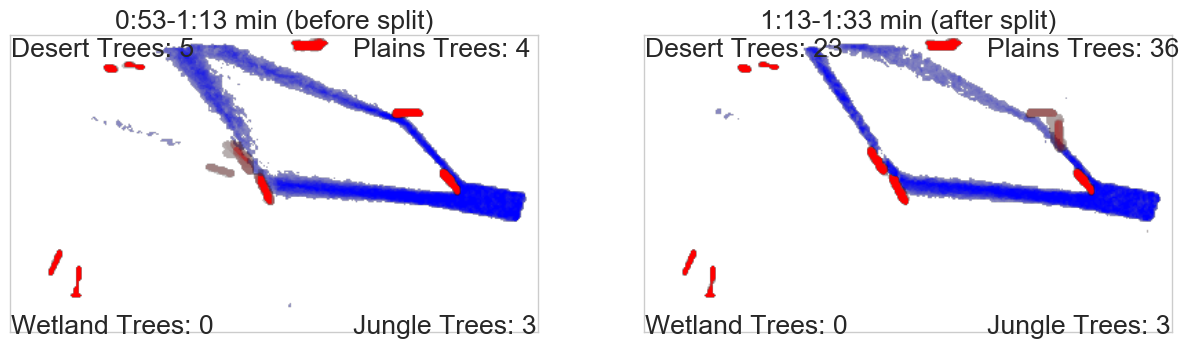

--------------------------------------------------------
--------------------------------------------------------

Split @ 3:20 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Decrease in Jungle_Water water
Increase in Plains_Water water

******************************************************


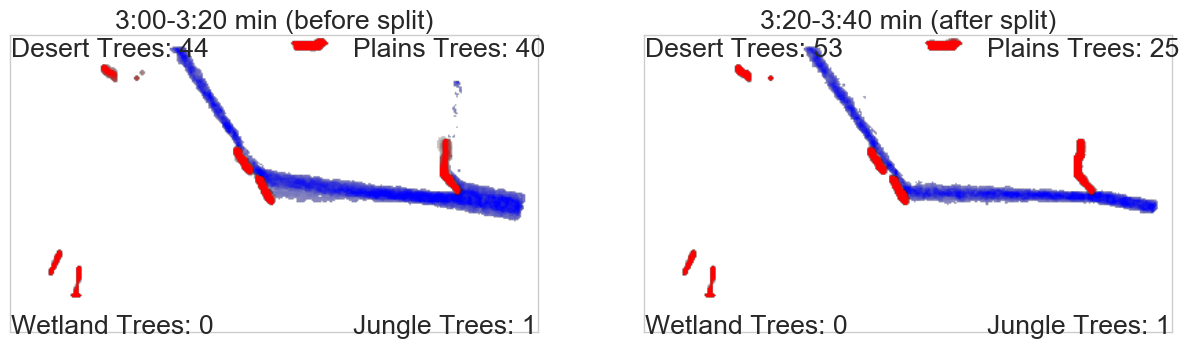

--------------------------------------------------------
--------------------------------------------------------

Split @ 3:56 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Jungle_Water water

******************************************************


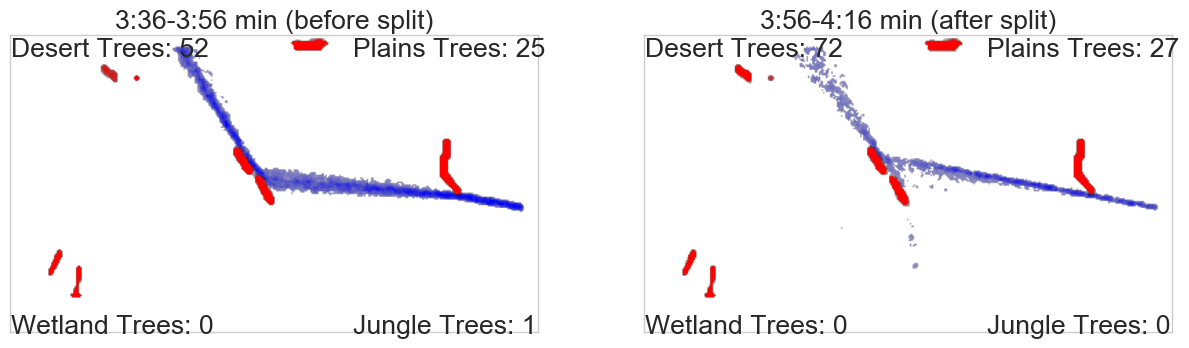

--------------------------------------------------------
--------------------------------------------------------



In [45]:
cw_plots.plot_log_positions(df_name=df_name, 
                            results=results, 
                            names=names, 
                            data_csvs=data_csvs, 
                            data_csvs_raw=data_csvs_raw, 
                            path = './../data/test_data/')

**Points of interest:**
- Split @ 1:13 min - increase in planes is triggered too early.
- Split @ 3:20 min - log position that causes this can be seen but the water flow is not clear.
- Split @ 3:56 min - increase in jungle is misleading

<hr />
### Test 4

In [46]:
df_name = 'df_4'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(
        data_csvs[df_name].values,
        num_breaks=5,
        starting_params=params,
        sensitivity=3)
results[df_name] = em_res

In [47]:
results['df_4']['breaks']

array([  0,  80, 158, 301, 391])

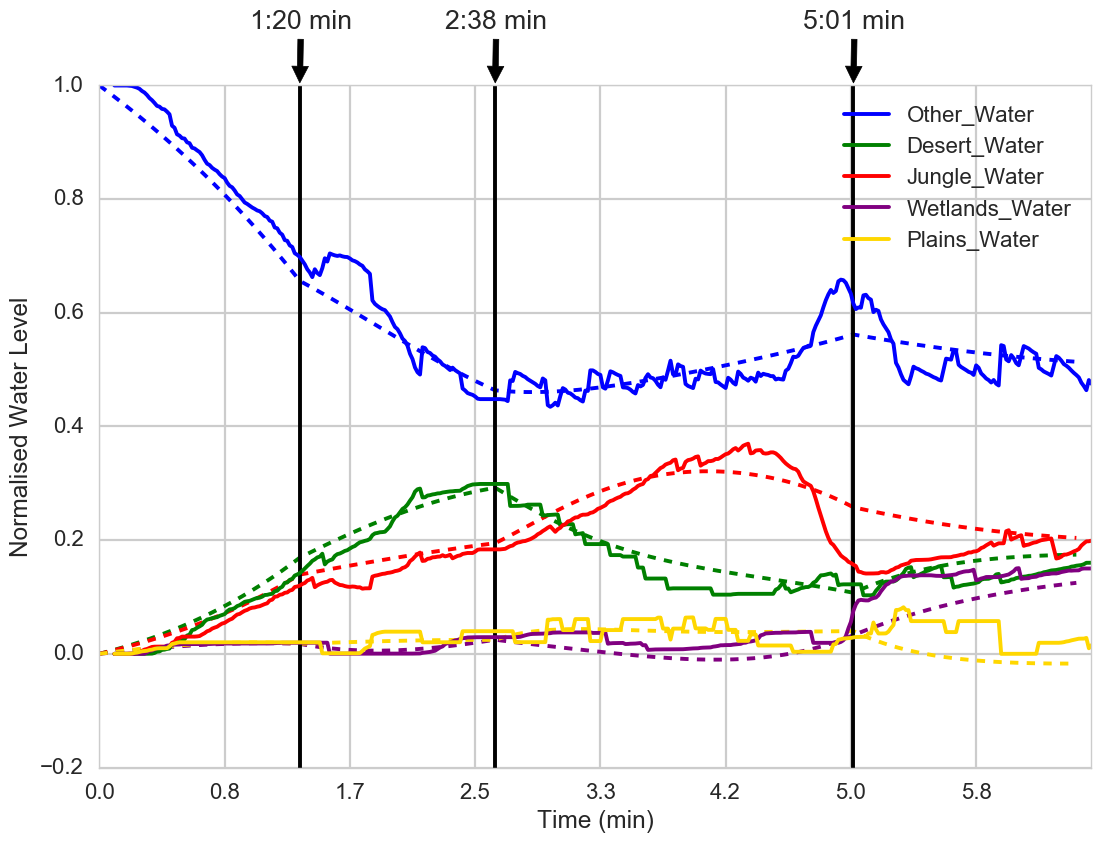

In [48]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

File: test4-2017-11-10T09-24.csv
Split @ 1:20 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Decrease in Jungle_Water water
Increase in Plains_Water water

******************************************************


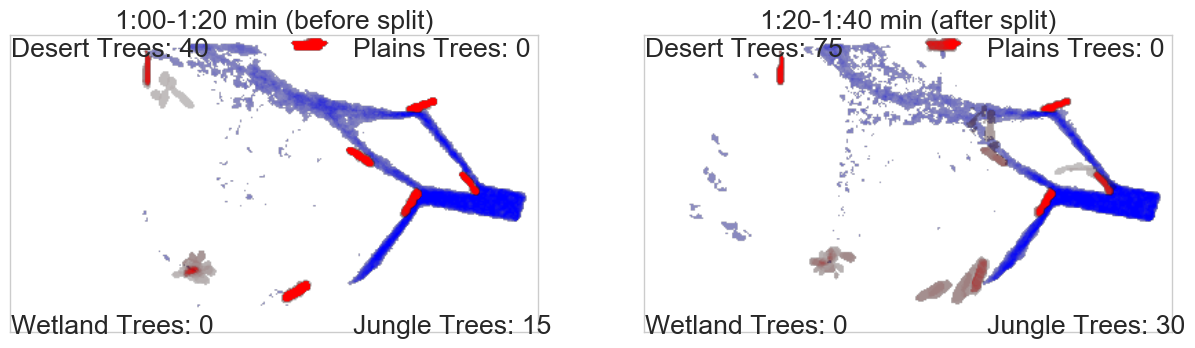

--------------------------------------------------------
--------------------------------------------------------

Split @ 2:38 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Decrease in Jungle_Water water
Increase in Wetlands_Water water
Decrease in Plains_Water water

******************************************************


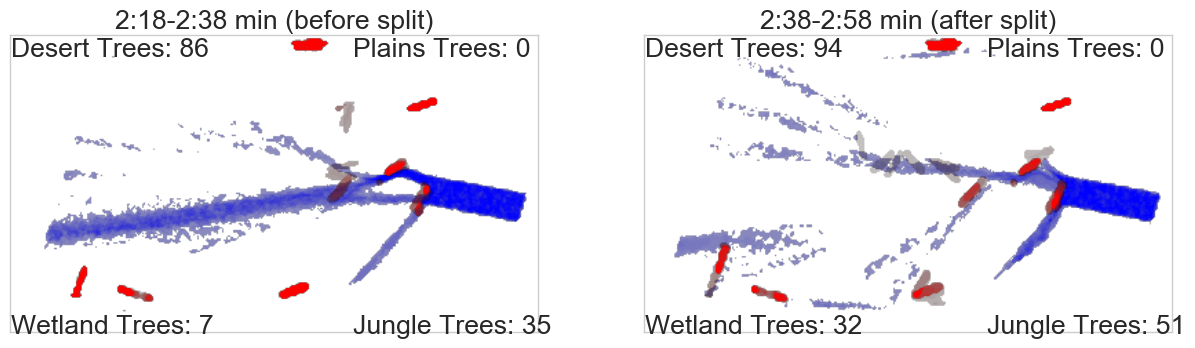

--------------------------------------------------------
--------------------------------------------------------

Split @ 5:01 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Increase in Jungle_Water water
Decrease in Wetlands_Water water
Increase in Plains_Water water

******************************************************


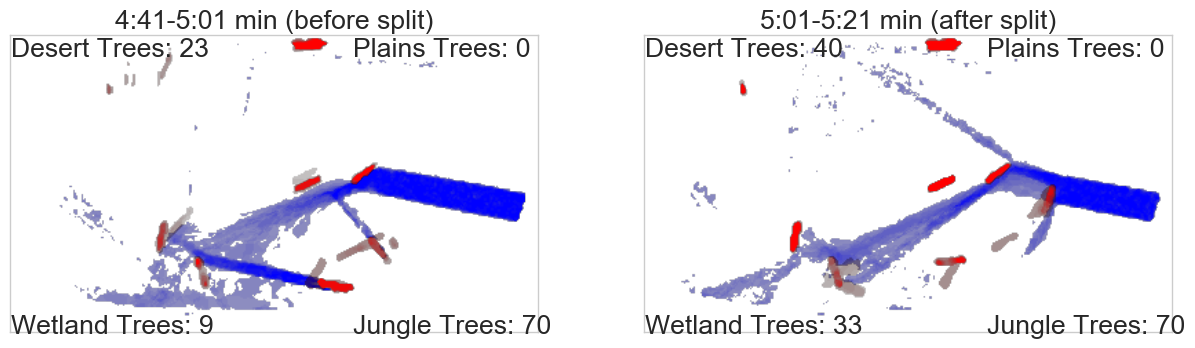

--------------------------------------------------------
--------------------------------------------------------



In [49]:
cw_plots.plot_log_positions(df_name=df_name, 
                            results=results, 
                            names=names, 
                            data_csvs=data_csvs, 
                            data_csvs_raw=data_csvs_raw, 
                            path = './../data/test_data/')

**Points of interest:**
- Split @ 1:20 min - decrease in most biomes is clear
- Split @ 5:01 min - labels are not clear

<hr />
### Test 5

In [20]:
df_name = 'df_5'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(
        data_csvs[df_name].values,
        num_breaks=5,
        starting_params=params,
        sensitivity=1)
    results[df_name] = em_res

starting [  0  79 158 237 316 397]
updated [  0  80 157 242 323 397]
checking convergence 0
starting [  0  80 157 242 323 397]
updated [  0  80 157 242 323 397]
checking convergence 1
Converged


In [27]:
results['df_5']['breaks']

array([  0,  80, 157, 242, 323, 397])

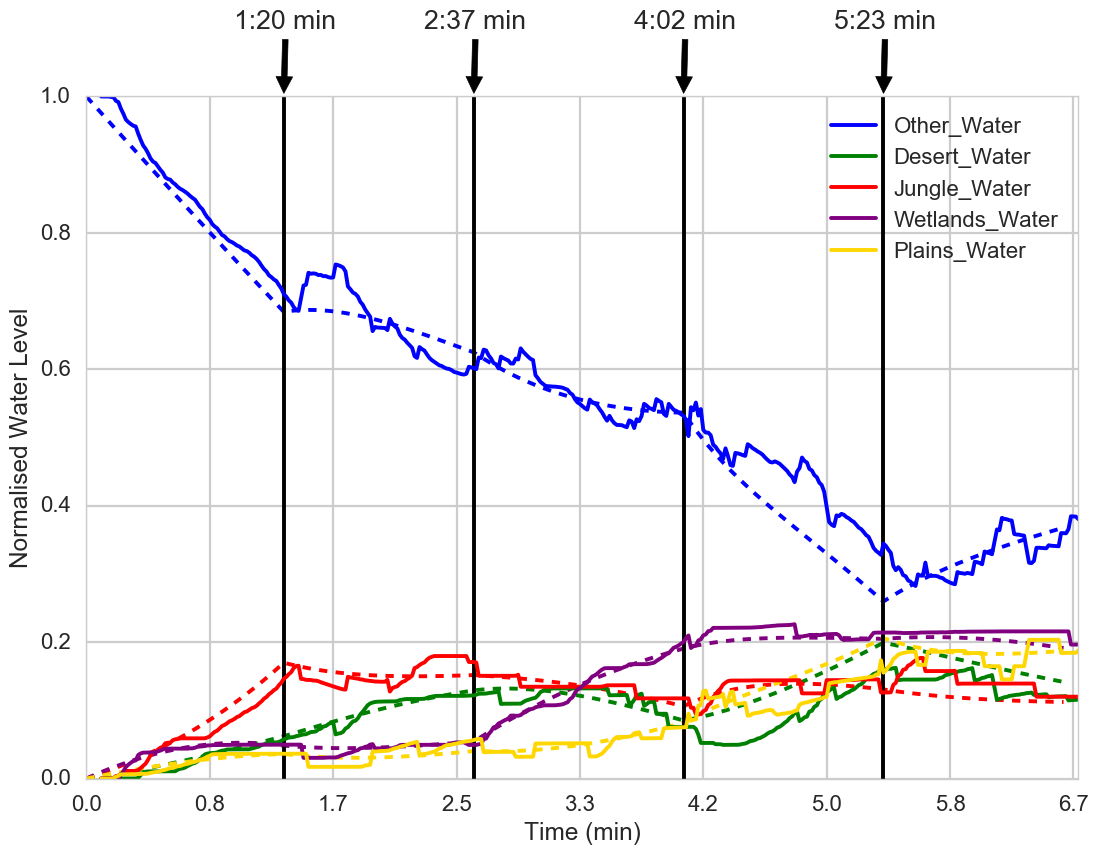

In [21]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

File: test5-2017-11-16T11-41.csv
Split @ 1:20 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Decrease in Jungle_Water water
Increase in Wetlands_Water water
Increase in Plains_Water water

******************************************************


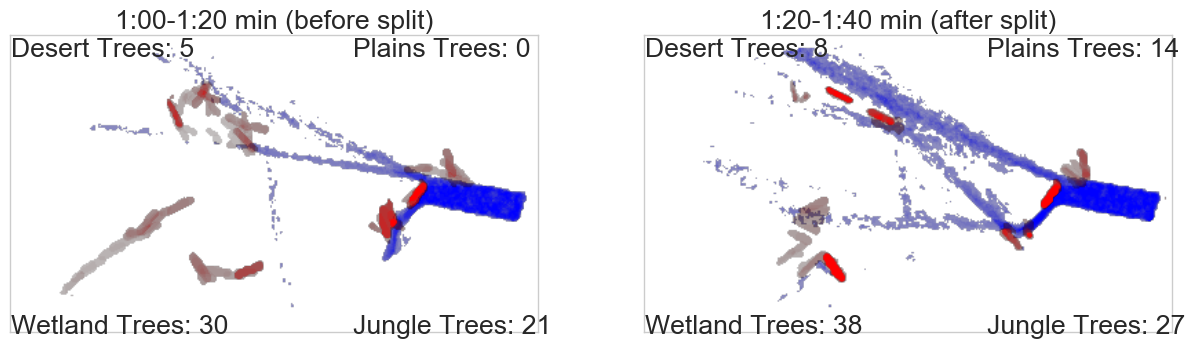

--------------------------------------------------------
--------------------------------------------------------

Split @ 2:37 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Decrease in Jungle_Water water
Increase in Wetlands_Water water
Increase in Plains_Water water

******************************************************


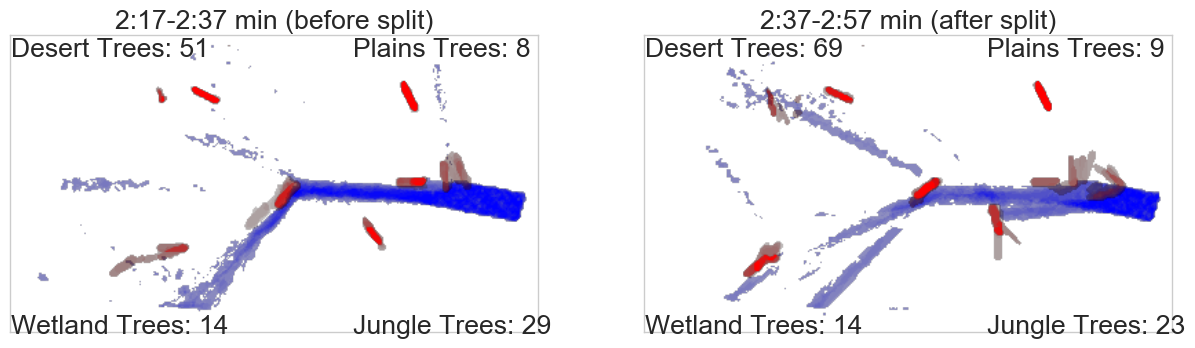

--------------------------------------------------------
--------------------------------------------------------

Split @ 4:02 min
***********POSSIBLE THINGS TO NOTICE******************
Increase in Desert_Water water
Decrease in Jungle_Water water
Increase in Wetlands_Water water
Increase in Plains_Water water

******************************************************


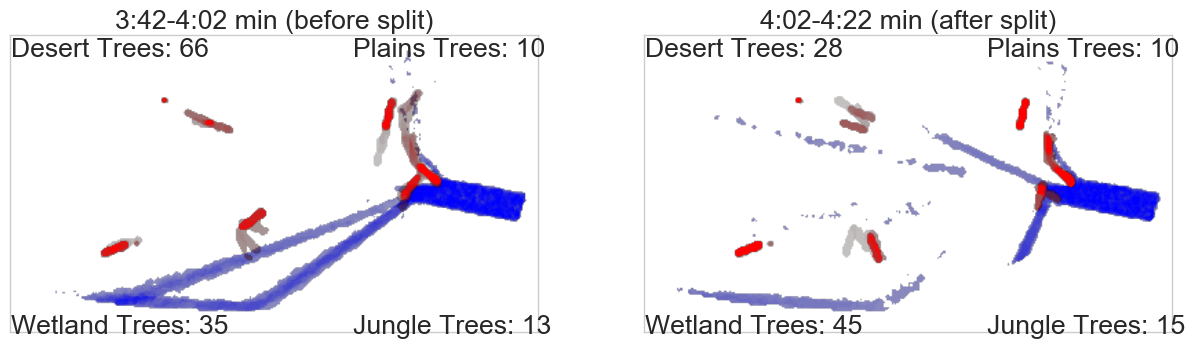

--------------------------------------------------------
--------------------------------------------------------

Split @ 5:23 min
***********POSSIBLE THINGS TO NOTICE******************
Decrease in Desert_Water water
Increase in Jungle_Water water
Decrease in Wetlands_Water water
Decrease in Plains_Water water

******************************************************


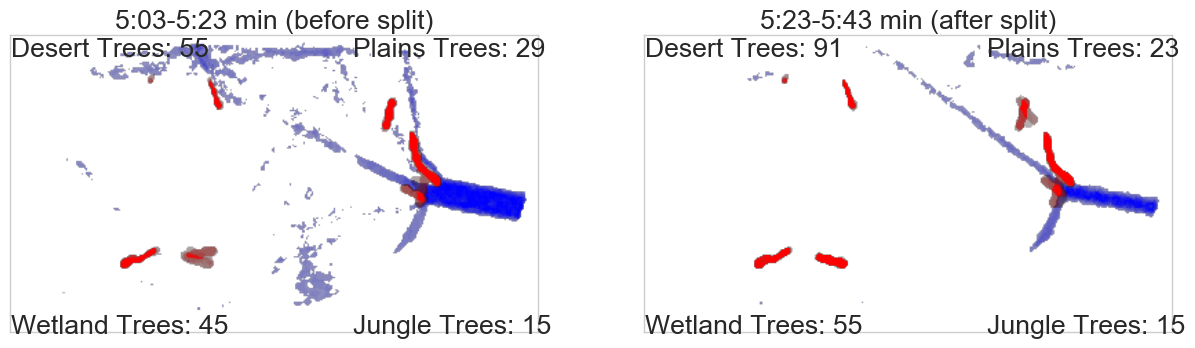

--------------------------------------------------------
--------------------------------------------------------



In [22]:
cw_plots.plot_log_positions(df_name=df_name, 
                            results=results, 
                            names=names, 
                            data_csvs=data_csvs, 
                            data_csvs_raw=data_csvs_raw, 
                            path = './../data/test_data/')

**Points of interest:**
- Split @ 1:20 min - clear decrease in jungle. Increase in Desert is clear.
- Split @ 2:37 min - Increase in wetlands is clear.
- Split @ 4:02 min - Increase in wetlands, increase in plains is clear
- Split @ 5:23 min - Increase in jungle is clear.